# THEME 7: Boosting Algorithms

## Requirements (from email)

**Objective:** Master sequential ensemble methods that correct previous model errors

### Sub-topics:

- Boosting vs bagging theory
- Sequential learning and error correction
- AdaBoost (Adaptive Boosting) with sample weighting
- Gradient Boosting Machines (GBM) with residual fitting
- XGBoost (Extreme Gradient Boosting) with regularization
- LightGBM (Light Gradient Boosting) with leaf-wise growth
- Key hyperparameters: learning_rate, n_estimators, max_depth
- Learning rate vs number of estimators trade-off
- Early stopping to prevent overfitting
- Comparison: speed, memory, performance

### Hands-on -

**AdaBoost Deep Dive**

- Dataset: Titanic (classification)
- Implement AdaBoost with decision stumps
- Visualize sample weight evolution over iterations
- Compare different base estimators (depth 1, 3, 5)
- Tune n_estimators [10, 50, 100, 200, 500]
- Tune learning_rate [0.1, 0.5, 1.0, 2.0]
- Plot training accuracy vs iterations
- Analyze: which passengers are hardest to classify?

**Gradient Boosting Comparison (Classification)**

- Dataset: Titanic
- Implement three methods: sklearn GradientBoostingClassifier, XGBClassifier, LGBMClassifier
- Use same hyperparameters for fair comparison (n_estimators=100, learning_rate=0.1)
- Measure: accuracy, training time, prediction time, memory usage
- Plot learning curves for all three methods on same graph
- Compare feature importance across methods
- Recommend: which algorithm when?

**Gradient Boosting Comparison (Regression)**

- Dataset: California Housing
- Implement three methods: sklearn GradientBoostingRegressor, XGBRegressor, LGBMRegressor
- Use same hyperparameters for fair comparison
- Measure: R², RMSE, training time, prediction time, memory
- Plot learning curves showing sequential improvement
- Compare feature importance across methods
- Analyze: which features drive predictions?

**XGBoost Hyperparameter Tuning**

- Dataset: California Housing (regression)
- Baseline with default parameters
- Tune tree structure: max_depth [3, 5, 7, 9], min_child_weight [1, 3, 5, 7]
- Tune boosting: learning_rate [0.01, 0.05, 0.1, 0.3], n_estimators [100, 200, 500, 1000]
- Tune sampling: subsample [0.6, 0.8, 1.0], colsample_bytree [0.6, 0.8, 1.0]
- Tune regularization: reg_alpha [0, 0.01, 0.1, 1], reg_lambda [0, 1, 10, 100]
- Use GridSearchCV or RandomizedSearchCV
- Implement early stopping
- Create optimal configuration guide

**LightGBM Speed Benchmark**

- Dataset: California Housing (larger data)
- Implement LightGBM with leaf-wise tree growth
- Tune LightGBM-specific: num_leaves [31, 63, 127], min_data_in_leaf [20, 50, 100]
- Tune sampling: feature_fraction, bagging_fraction, bagging_freq
- Compare speed with XGBoost and sklearn GBM (same performance target)
- Measure: training time, prediction time, memory usage
- Early stopping demonstration
- Recommend: when LightGBM vs XGBoost?

### Deliverables:

- Random Forest baseline (from Theme 4) for comparison
- Chosen boosting algorithm implementation
- Performance comparison: your method vs Random Forest
- Hyperparameter tuning results (tables + plots)
- Learning curves showing sequential improvement
- Feature importance chart (if applicable)
- Speed/memory benchmarks (if comparing algorithms)
- Visualization showing boosting iterations (convergence)
- Discussion:
  - Why boosting outperforms/underperforms Random Forest
  - When to use your chosen boosting method
  - Computational trade-offs

In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier, GradientBoostingRegressor

## Load the pickles and construct the X and y

In [10]:
dataset_california = pd.read_pickle('./cali.pkl')
dataset_titanic = pd.read_pickle('./titanic.pkl')

In [13]:
X_t = dataset_titanic.drop(columns=["Survived", "PassengerId", "Name", "Ticket", "officialTitle"])
y_t = dataset_titanic["Survived"]

X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(
    X_t, y_t, test_size=0.2, stratify=y_t, random_state=42
)

In [14]:
X_c = dataset_california.drop(columns=["MedHouseVal"])
y_c = dataset_california["MedHouseVal"]

X_train_c, X_test_c, y_train_c, y_test_c = train_test_split(
    X_c, y_c, test_size=0.2, random_state=42
)

## Titanic

### Random Forest baseline

In [15]:
rf = RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1)
rf.fit(X_train_t, y_train_t)

rf_pred = rf.predict(X_test_t)
rf_acc = accuracy_score(y_test_t, rf_pred)

print("Random Forest test accuracy:", rf_acc)

Random Forest test accuracy: 0.7552447552447552


### AdaBoost Deep Dive
#### Ada Boost with decision stumps

In [17]:
stump = DecisionTreeClassifier(max_depth=1, random_state=42)

ada_stump = AdaBoostClassifier(
    estimator=stump,
    n_estimators=100,
    learning_rate=1.0,
    random_state=42
)
ada_stump.fit(X_train_t, y_train_t)

ada_pred = ada_stump.predict(X_test_t)
ada_acc = accuracy_score(y_test_t, ada_pred)

print("AdaBoost (stump) test accuracy:", ada_acc)
print("RF test accuracy:", rf_acc)

AdaBoost (stump) test accuracy: 0.8041958041958042
RF test accuracy: 0.7552447552447552


#### Compare the base estimators

In [19]:
depths = [1, 3, 5]
depth_results = {}

for d in depths:
    base = DecisionTreeClassifier(max_depth=d, random_state=42)
    ada = AdaBoostClassifier(estimator=base, n_estimators=100, learning_rate=1.0, random_state=42)
    ada.fit(X_train_t, y_train_t)
    depth_results[d] = accuracy_score(y_test_t, ada.predict(X_test_t))

depth_results

{1: 0.8041958041958042, 3: 0.7972027972027972, 5: 0.7552447552447552}

#### Tune n_estimators & learning_rate

In [20]:
param_grid = {
    "n_estimators": [10, 50, 100, 200, 500],
    "learning_rate": [0.1, 0.5, 1.0, 2.0],
}

grid = GridSearchCV(
    AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=1, random_state=42), random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring="accuracy",
    n_jobs=-1
)

grid.fit(X_train_t, y_train_t)

print("Best params:", grid.best_params_)
print("Best CV accuracy:", grid.best_score_)

best_ada = grid.best_estimator_
print("Best AdaBoost test accuracy:", best_ada.score(X_test_t, y_test_t))

Best params: {'learning_rate': 1.0, 'n_estimators': 200}
Best CV accuracy: 0.8055377574370709
Best AdaBoost test accuracy: 0.7972027972027972


#### Plot training accuracy vs iterations

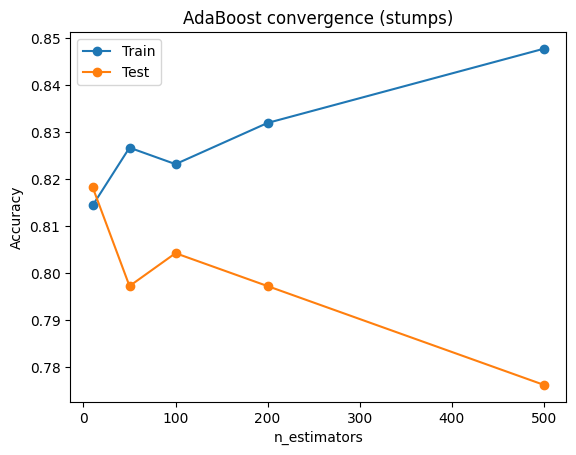

In [21]:
iters = [10, 50, 100, 200, 500]
train_acc = []
test_acc = []

for n in iters:
    model = AdaBoostClassifier(
        estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
        n_estimators=n,
        learning_rate=1.0,
        random_state=42
    )
    model.fit(X_train_t, y_train_t)
    train_acc.append(model.score(X_train_t, y_train_t))
    test_acc.append(model.score(X_test_t, y_test_t))

plt.figure()
plt.plot(iters, train_acc, marker="o", label="Train")
plt.plot(iters, test_acc, marker="o", label="Test")
plt.xlabel("n_estimators")
plt.ylabel("Accuracy")
plt.title("AdaBoost convergence (stumps)")
plt.legend()
plt.show()

#### "Hardest passengers to classify"

In [22]:
best_pred = best_ada.predict(X_test_t)
hard_mask = (best_pred != y_test_t)

hard_samples = dataset_titanic.loc[X_test_t.index][hard_mask].copy()
hard_samples["predicted"] = best_pred[hard_mask.to_numpy()]

hard_samples[["Survived", "predicted", "Age", "Fare", "FamilySize", "Sex_male", "Pclass_3", "Embarked_S"]].head(15)

,Survived,predicted,Age,Fare,FamilySize,Sex_male,Pclass_3,Embarked_S
483,1,0,63.0,9.5875,1,False,True,True
400,1,0,39.0,7.9250,1,True,True,True
501,0,1,21.0,7.7500,1,False,True,False
673,1,0,31.0,13.0000,1,True,False,True
789,0,1,46.0,79.2000,1,True,False,False
199,0,1,24.0,13.0000,1,False,False,True
74,1,0,32.0,56.4958,1,True,True,True
816,0,1,23.0,7.9250,1,False,True,True
49,0,1,18.0,17.8000,2,False,True,True
505,0,1,18.0,108.9000,2,True,False,False


In [23]:
hard_samples["Sex_male"].value_counts(), hard_samples["Pclass_3"].value_counts()

(Sex_male
 True     18
 False    11
 Name: count, dtype: int64,
 Pclass_3
 False    15
 True     14
 Name: count, dtype: int64)

### Gradient Boosting

#### GradientBoostingClassifier

In [24]:
gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbc.fit(X_train_t, y_train_t)

gbc_acc = accuracy_score(y_test_t, gbc.predict(X_test_t))
print("GradientBoostingClassifier test accuracy:", gbc_acc)

GradientBoostingClassifier test accuracy: 0.7902097902097902


### California - Gradient Boosting Regressor

In [26]:
gbr = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gbr.fit(X_train_c, y_train_c)

pred_c = gbr.predict(X_test_c)
rmse = mean_squared_error(y_test_c, pred_c)
r2 = r2_score(y_test_c, pred_c)

print("GBR RMSE:", rmse)
print("GBR R²  :", r2)

GBR RMSE: 0.2770306555532327
GBR R²  : 0.7885922180378219


### Feature importances across algorithms

In [28]:
def top_importances(model, feature_names, top_n=10):
    imp = pd.Series(model.feature_importances_, index=feature_names).sort_values(ascending=False)
    return imp.head(top_n)

print("AdaBoost top features:\n", top_importances(best_ada, X_train_t.columns))
print("\nRF top features:\n", top_importances(rf, X_train_t.columns))
print("\nGBC top features:\n", top_importances(gbc, X_train_t.columns))

AdaBoost top features:
 Age                  0.414113
Fare                 0.214964
Sex_male             0.104547
FamilySize           0.090633
Pclass_3             0.057280
fareBin_Expensive    0.031268
SibSp                0.028073
Pclass_2             0.021415
ageGroup_Senior      0.021139
Embarked_C           0.016567
dtype: float64

RF top features:
 Age                  0.220044
Fare                 0.207228
Sex_male             0.135141
Sex_female           0.119048
Pclass_3             0.051062
FamilySize           0.043404
SibSp                0.027143
Parch                0.026113
Pclass_1             0.024193
fareBin_Expensive    0.021235
dtype: float64

GBC top features:
 Sex_male          0.208255
Sex_female        0.203256
Age               0.192988
Fare              0.143080
Pclass_3          0.125405
Pclass_1          0.042512
FamilySize        0.030058
SibSp             0.014383
fareBin_Medium    0.009933
Embarked_C        0.008051
dtype: float64


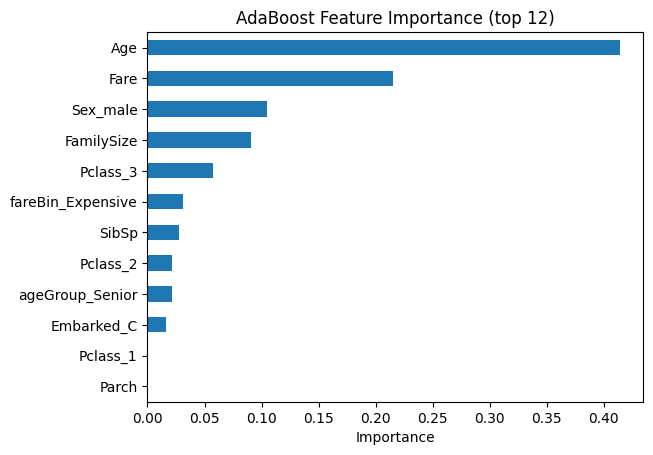

In [29]:
imp = top_importances(best_ada, X_train_t.columns, top_n=12).sort_values()
plt.figure()
imp.plot(kind="barh")
plt.title("AdaBoost Feature Importance (top 12)")
plt.xlabel("Importance")
plt.show()

### Speed benchmark

In [30]:
def benchmark_classifier(model, X_train, y_train, X_test, y_test, name):
    t0 = time.perf_counter()
    model.fit(X_train, y_train)
    train_s = time.perf_counter() - t0

    t1 = time.perf_counter()
    pred = model.predict(X_test)
    pred_s = time.perf_counter() - t1

    return {
        "model": name,
        "test_acc": accuracy_score(y_test, pred),
        "train_s": train_s,
        "pred_s": pred_s
    }

bench = []
bench.append(benchmark_classifier(RandomForestClassifier(n_estimators=300, random_state=42, n_jobs=-1),
                                  X_train_t, y_train_t, X_test_t, y_test_t, "RandomForest"))
bench.append(benchmark_classifier(AdaBoostClassifier(
                                    estimator=DecisionTreeClassifier(max_depth=1, random_state=42),
                                    n_estimators=grid.best_params_["n_estimators"],
                                    learning_rate=grid.best_params_["learning_rate"],
                                    random_state=42),
                                  X_train_t, y_train_t, X_test_t, y_test_t, "AdaBoost(best)"))
bench.append(benchmark_classifier(GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42),
                                  X_train_t, y_train_t, X_test_t, y_test_t, "GradientBoosting"))

pd.DataFrame(bench)

,model,test_acc,train_s,pred_s
0,RandomForest,0.755245,0.390316,0.049688
1,AdaBoost(best),0.797203,0.228173,0.014399
2,GradientBoosting,0.790210,0.089554,0.001136
